In [5]:
import matplotlib.pylab as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from megspikes.scoring.scoring import distance_to_resection_hull
from megspikes.database.database import check_and_read_from_dataset

from utils.plot_paper_images import fig4_one_row
from utils.utils import setup_case_manager

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
case = setup_case_manager(10)
save_path = case.root.parent / 'Results'
save_path.mkdir(exist_ok=True)

In [8]:
save_path

PosixPath('/media/cdm/Valerii/Valerii/Gdrive/Results')

## Figure 2

## Figure 3

In [ ]:

case = setup_case_manager(1)     

clusters_auto = xr.open_dataset(case.cluster_dataset.with_name(f'{case.case}_clusters_manually_checked.nc'))

In [ ]:
clusters_auto


## Figure 4

In [ ]:
fig4_table = pd.DataFrame(columns=[
    'case', 'case_name', 'detection type', 'n_sources_resection', 'n_sources',
    'n_sources_to_n_sources_resection', 'distance to resection margin (mm)'])

n = 0

for subj in range(1, 8):
    case = setup_case_manager(subj)

    resection = np.load(
        case.basic_folders['resection mask'].with_name('resection.npy'))
    resection_stc = np.load(
        case.basic_folders['resection mask'].with_name('resection_stc.npy'))

    clusters_auto = xr.open_dataset(
        case.cluster_dataset.with_name(f'{case.case}_clusters_manually_checked.nc'))

    fwd_mni = clusters_auto.fwd_mni_coordinates.values

    manual_stc = np.load(case.basic_folders['MANUAL'] / 'manual_stc.npy')
    peak_stc = clusters_auto.iz_prediction.loc[:, 'peak'].values
    slope_stc = clusters_auto.iz_prediction.loc[:, 'slope'].values

    if sum(slope_stc > 0) == 0:
        dist_resection_to_slope = np.NAN
    else:
        dist_resection_to_slope = distance_to_resection_hull(
            fwd_mni[resection_stc > 0], fwd_mni[slope_stc > 0])
    dist_resection_to_peak = distance_to_resection_hull(
        fwd_mni[resection_stc > 0], fwd_mni[peak_stc > 0])
    dist_resection_to_manual = distance_to_resection_hull(
        fwd_mni[resection_stc > 0], fwd_mni[manual_stc > 0])

    fig4_table, n = fig4_one_row(n, case, fig4_table, subj, 'manual', fwd_mni,
                                 resection_stc,  manual_stc, dist_resection_to_manual)

    fig4_table, n = fig4_one_row(n, case, fig4_table, subj, 'slope', fwd_mni,
                                 resection_stc,  slope_stc, dist_resection_to_slope)

    fig4_table, n = fig4_one_row(n, case, fig4_table, subj, 'peak', fwd_mni,
                                 resection_stc,  peak_stc, dist_resection_to_peak)



In [ ]:
fig4_table

#### Save table with results

In [ ]:
fig4_table.to_excel(save_path / "figure_4_table.xlsx", index=False)


#### Plot figure 4

In [ ]:
sns.set(style="whitegrid",font_scale=2)

fig4_table.rename(
    columns={'n_sources_to_n_sources_resection': 'N sources\ndetection to\nresection'},
    inplace=True)
f, ax = plt.subplots(figsize=(15, 15))
dy = 'detection_type'
dx = 'distance_resection'
ort="h"
pal = "Set2"
size = 'N sources\ndetection to\nresection'

ax= sns.scatterplot(x=dx, y=dy, data=fig4_table, hue='case', size=size,
                    zorder = 10, palette=pal, sizes=(1,1500), alpha=.6)

plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend title
ax.legend(loc='upper right',ncol=1, bbox_to_anchor=(1.25, 1)) # , title="Title"



ax=sns.boxplot(x=dx, y=dy, data=fig4_table, color="black",
        width=.15, zorder=0, showcaps=True,
        boxprops = {'facecolor':'none', "zorder":10}, showfliers=True,
        whiskerprops = {'linewidth':2, "zorder":10},
        saturation=1, orient=ort)

for case, color in zip(range(1,8), sns.color_palette(pal, n_colors=8, as_cmap=True).colors):
    ax.plot(fig4_table.loc[fig4_table['case']==case, 'distance_resection'], [0, 1, 2],
            lw=3, c=color, alpha=0.4)

ax.set_xlabel('distance to resection margin [mm]')    
ax.set_ylabel('IZ estimation')    

plt.tight_layout()
plt.axvline(20, 0, 1, c='r')
plt.savefig(save_path / 'Figure_4_results.png', dpi=300)

## Figure 5

In [ ]:
df = pd.DataFrame([], columns=['case', 'case_name', 'sensors', 'cluster', 'n_events',
                          'distance', 'peak_evoked', 'peak_sources'])
n = 0
for subj in range(1, 8):
    case = setup_case_manager(subj)
    ds = xr.open_dataset(
        case.cluster_dataset.with_name(f'{case.case}_clusters_manually_checked.nc'))

    trans = mne.read_trans(
        case.basic_folders['forward_model'] / 'checked_visually_trans.fif')
    fwd = mne.read_forward_solution(
        case.basic_folders['forward_model'] / 'forward_ico5.fif')

    info = mne.io.read_info(case.fif_file)
    info_grad = mne.pick_info(info, mne.pick_types(info, meg='grad'))
    info_mag = mne.pick_info(info, mne.pick_types(info, meg='mag'))

    clusters_ids = check_and_read_from_dataset(
        ds, 'cluster_properties',
        dict(cluster_property=['cluster_id']), dtype=np.int64)

    for cluster in clusters_ids.flatten():
        df.loc[n, 'case'] = subj
        df.loc[n, 'case_name'] = case.case
        df.loc[n, 'cluster'] = cluster

        sensors = check_and_read_from_dataset(
            ds, 'cluster_properties',
            dict(cluster_property=['sensors'], cluster=cluster), dtype=np.int64)

        sensors_name = 'grad' if sensors == 0 else 'mag'
        df.loc[n, 'sensors'] = sensors_name
        info = info_grad if sensors == 0 else info_mag

        time_peak = check_and_read_from_dataset(
            ds, 'cluster_properties',
            dict(cluster_property=['time_peak'], cluster=cluster), dtype=np.int64)

        df.loc[n, 'n_events'] = check_and_read_from_dataset(
            ds, 'cluster_properties',
            dict(cluster_property=['n_events'], cluster=cluster), dtype=np.int64).flatten()[0]

        evoked = check_and_read_from_dataset(ds, 'evoked', dict(cluster=cluster))
        evoked = evoked[ds.channel_names.attrs[sensors_name].tolist(), :]

        stc = check_and_read_from_dataset(
            ds, 'mne_localization', dict(cluster=cluster, sensors=sensors_name))

        # Find a channel with max amplitude at the peak for the cluster
        max_ch_inx = np.abs(evoked[:, time_peak]).argmax()

        chs_meg = info['chs'][max_ch_inx]['loc'][:3]
        chs_head = mne.transforms.apply_trans(
            info['dev_head_t']['trans'], chs_meg, move=True)
        chs_mni = mne.head_to_mni(
            chs_head, mri_head_t=trans, subject=case.case,
            subjects_dir=case.freesurfer_dir)

        # Find a source with max amplitude at the peak for the cluster
        vertices = [i['vertno'] for i in fwd['src']]
        max_src_inx = np.abs(stc[:, time_peak]).argmax()
        hemi = 0 if max_src_inx < len(vertices[0]) else 1
        max_src_inx = max_src_inx if hemi == 0 else max_src_inx - len(vertices[0])
        stc_mni = mne.vertex_to_mni(
            vertices[hemi][max_src_inx], hemis=hemi, subject=case.case,
            subjects_dir=case.freesurfer_dir)

        # Find a distance between max channel and max source in the mni space
        dist = np.linalg.norm(chs_mni - stc_mni, ord=2, axis=0)

        df.loc[n, 'distance'] = dist
        df.loc[n, 'peak_evoked'] = np.abs(evoked[max_ch_inx, time_peak]).flatten()[0]
        df.loc[n, 'peak_sources'] = np.abs(stc[np.abs(stc[:, time_peak]).argmax(), time_peak]).flatten()[0]
        n += 1

#### Save table with results

In [ ]:
df.to_excel(save_path / "figure_5_table_channel_dist_power.xlsx", index=False)


#### Prepare the table for plotting

In [ ]:
df.loc[:, 'peak_sources'] = df.loc[:, 'peak_sources'] * 1e+10
df.loc[:, 'n_events'] = np.float64(df.loc[:, 'n_events'].values)
df.loc[:, 'distance'] = np.float64(df.loc[:, 'distance'].values)
df.loc[:, 'peak_sources'] = np.float64(df.loc[:, 'peak_sources'].values)
df.loc[:, 'peak_evoked'] = np.float64(df.loc[:, 'peak_evoked'].values)

df.rename(columns={"distance": "Distance (mm)",
                   "sensors": "Sensors",
                   "peak_sources": "Activation AU",
                   "n_events": "N events",
                   "case": "Case"}, inplace=True)

df_grad = df.loc[df['Sensors']=='grad', :]
df_mag = df.loc[df['Sensors']=='mag', :]
# SEE: https://mne.tools/dev/glossary.html
df_grad.loc[:, "peak_evoked"] = np.abs(df_grad.loc[:, "peak_evoked"]) * 1e+13
df_mag.loc[:, "peak_evoked"] = np.abs(df_mag.loc[:, "peak_evoked"]) * 1e+15


#### Plot figure 5

In [ ]:
sns.set(style="whitegrid",font_scale=2)
df_mean = df.groupby(['Case', 'Sensors']).mean()
f, ax = plt.subplots(figsize=(10, 9))
sns.scatterplot(data=df_mean, x="Distance (mm)", y="Activation AU",
                hue="Case",  size='N events', palette="Set2",
                style="Sensors", markers = {"grad": "s", "mag": "o"},
                sizes=(50,1300), alpha=.6, ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4)
plt.tight_layout()
plt.savefig(save_path / 'Figure_5_distance_sources_mean_atoms.png', dpi=300)

## Supplementary: all cases STC

In [9]:
from utils.plot_paper_images import stc_surfaces
from megspikes.localization.localization import array_to_stc
import matplotlib.backends.backend_pdf

supplementary_fname = save_path / 'Supplementary_all_cases.pdf'

pdf = matplotlib.backends.backend_pdf.PdfPages(str(supplementary_fname))

for subj in range(1, 8):
    case = setup_case_manager(subj)

    resection_stc = np.load(
        case.basic_folders['resection mask'].with_name('resection_stc.npy'))

    clusters_auto = xr.open_dataset(
        case.cluster_dataset.with_name(f'{case.case}_clusters_manually_checked.nc'))

    manual_stc = np.load(case.basic_folders['MANUAL'] / 'manual_stc.npy')
    peak_stc = clusters_auto.iz_prediction.loc[:, 'peak'].values
    slope_stc = clusters_auto.iz_prediction.loc[:, 'slope'].values

    fig = stc_surfaces(
        case.freesurfer_dir,
        array_to_stc(resection_stc, case.fwd['ico5'], case.case),
        array_to_stc(manual_stc, case.fwd['ico5'], case.case),
        array_to_stc(peak_stc, case.fwd['ico5'], case.case),
        array_to_stc(slope_stc, case.fwd['ico5'], case.case))

    pdf.savefig(fig)
pdf.close()

KeyboardInterrupt: 

## Supplementary: all cases STC KIAS MEEG


ModuleNotFoundError: No module named 'surfer'

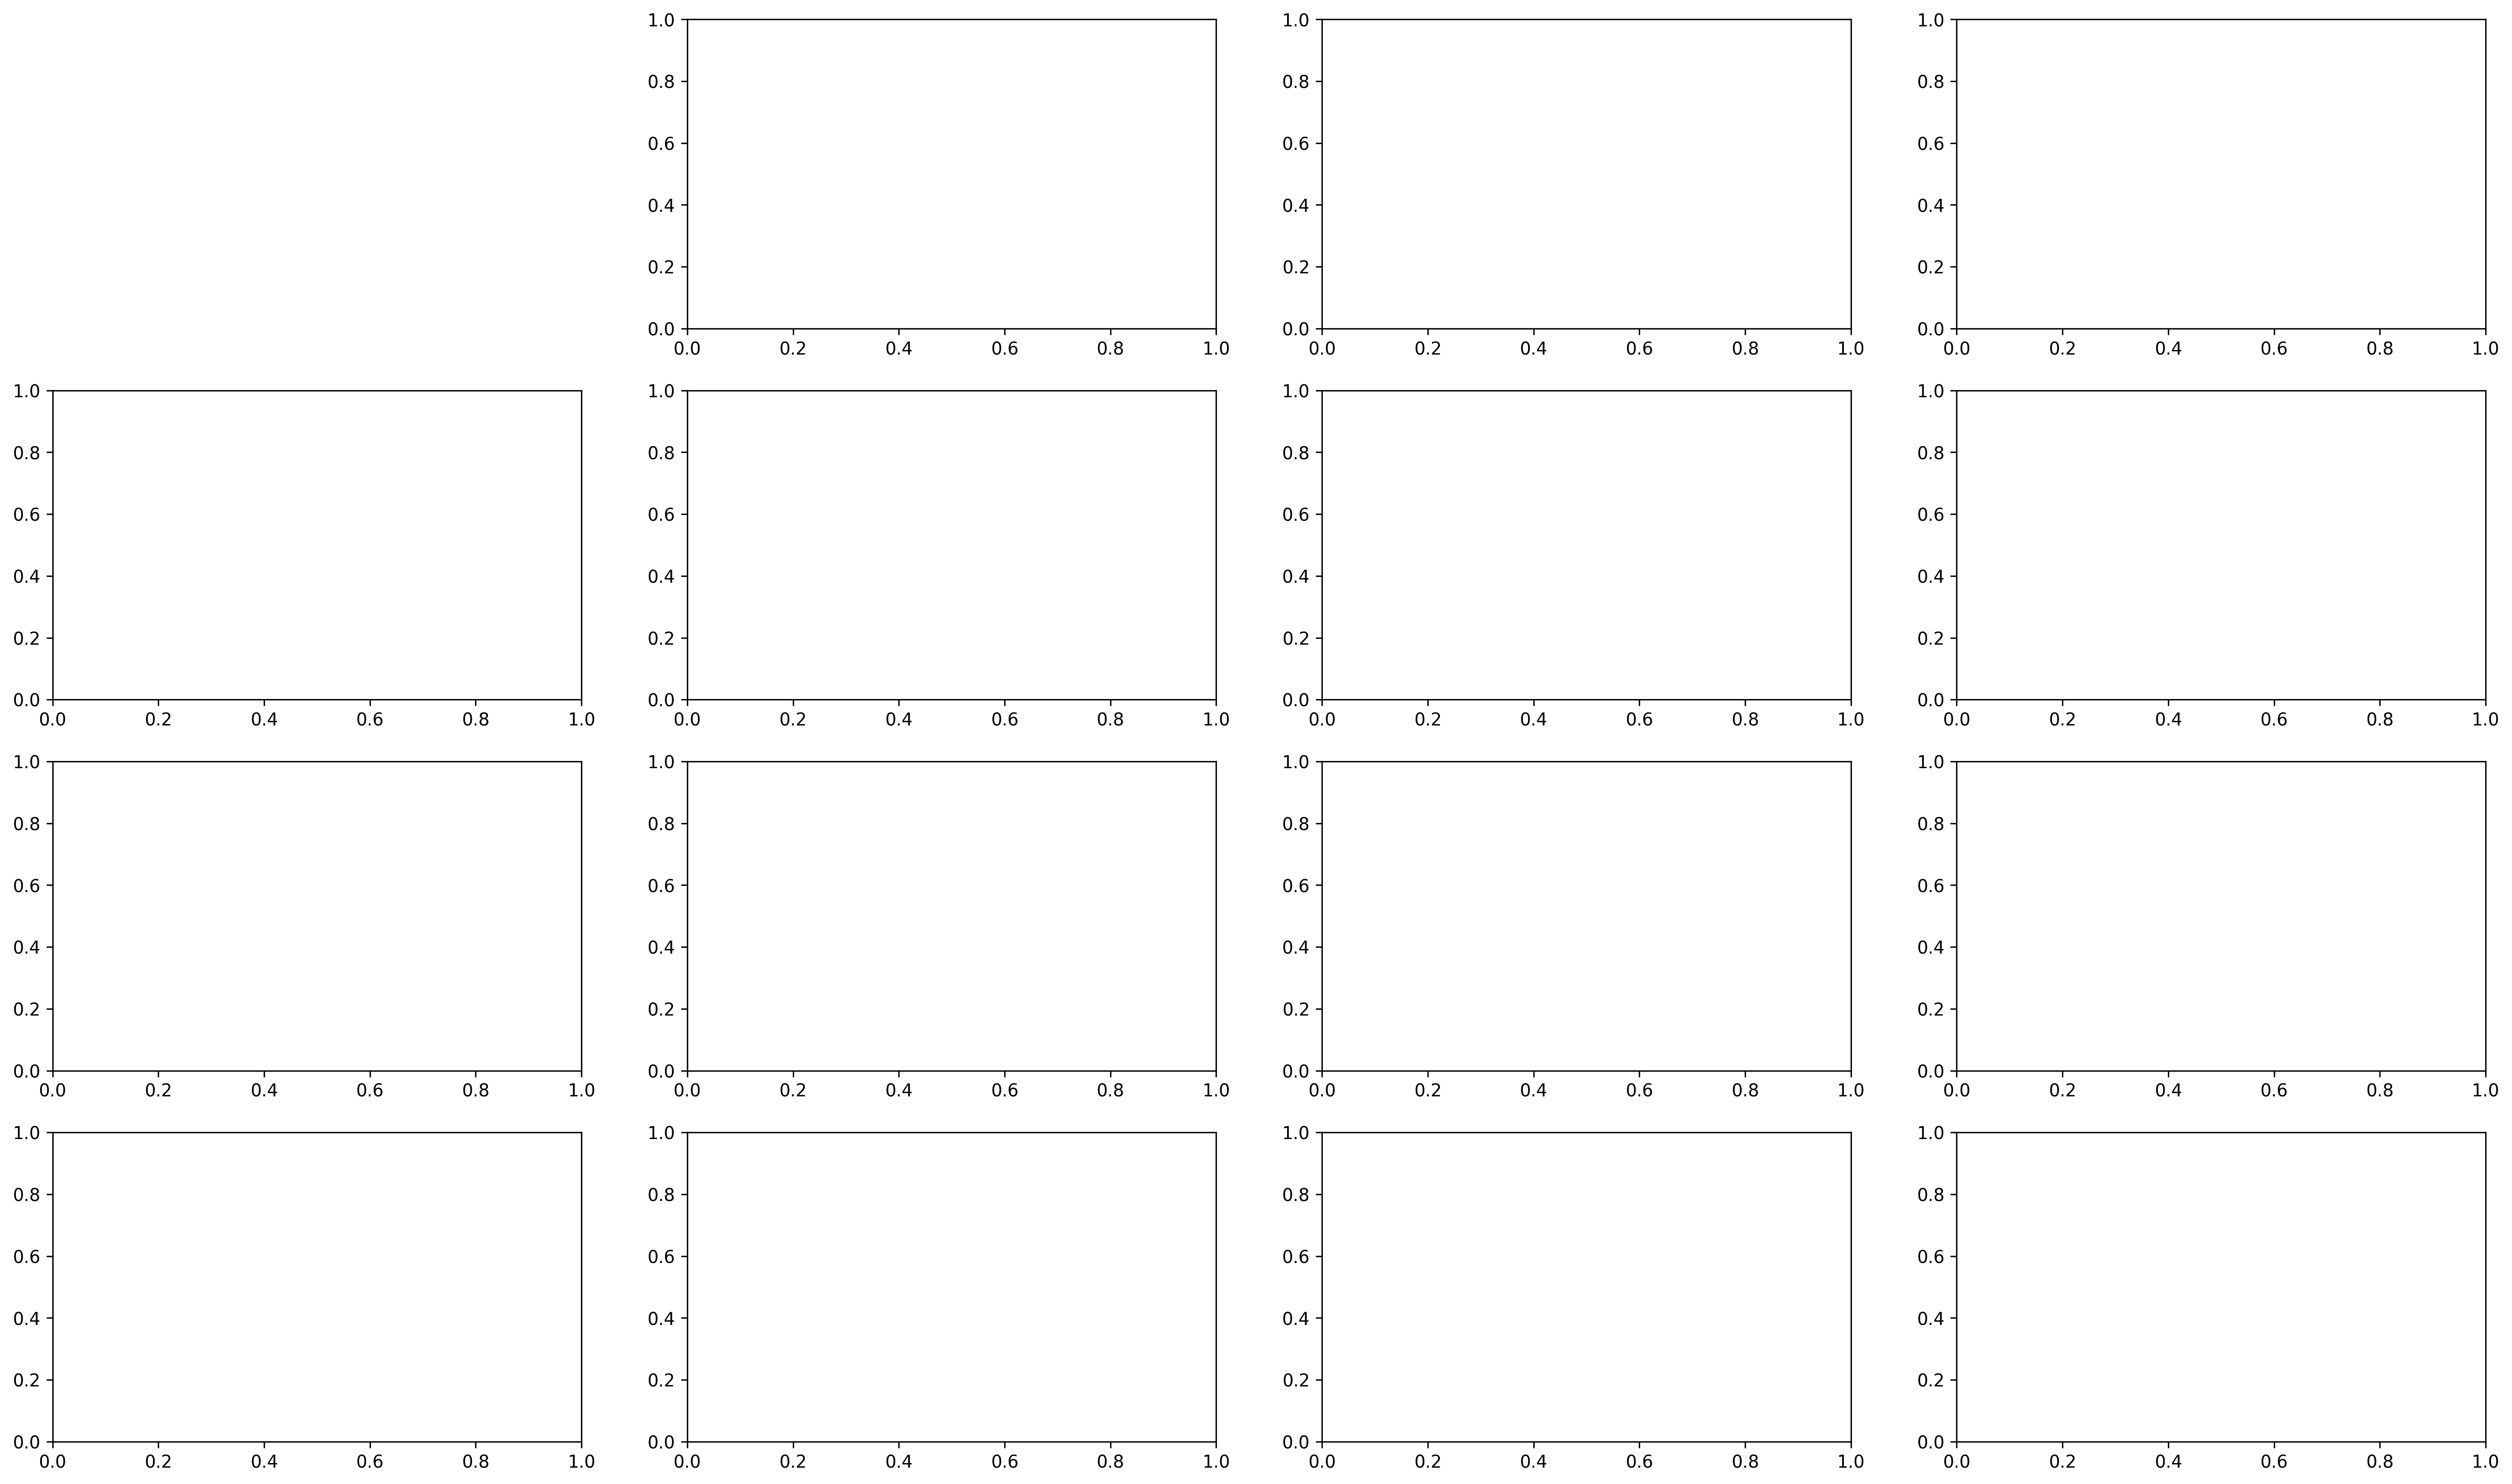

In [10]:
from utils.plot_paper_images import stc_surfaces_slope_peak
from megspikes.localization.localization import array_to_stc
import matplotlib.backends.backend_pdf



for subj in range(10,11):
    
    case = setup_case_manager(subj)
    
    supplementary_fname = save_path / f'IZ_{case.case}.pdf'

    pdf = matplotlib.backends.backend_pdf.PdfPages(str(supplementary_fname))
    
    

    #resection_stc = np.load(
        #case.basic_folders['resection mask'].with_name('resection_stc.npy'))

    clusters_auto = xr.open_dataset(
        case.cluster_dataset.with_name(f'{case.case}_clusters_manually_checked.nc'))

    #manual_stc = np.load(case.basic_folders['MANUAL'] / 'manual_stc.npy')
    peak_stc = clusters_auto.iz_prediction.loc[:, 'peak'].values
    slope_stc = clusters_auto.iz_prediction.loc[:, 'slope'].values

    fig = stc_surfaces_slope_peak(
        case.freesurfer_dir,
        array_to_stc(peak_stc, case.fwd['ico5'], case.case),
        array_to_stc(slope_stc, case.fwd['ico5'], case.case))

    pdf.savefig(fig)
    pdf.close()